In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

11.注释

- 11.1 加载和准备数据
- 11.2 下载和加载 celltypist 模型
- 11.3 细胞类型注释
- 11.4 可视化结果
- 11.5 分析之前的手动注释
- 11.6 进一步分析


In [3]:
# 11.1 加载要自动注释的数据
adata = sc.read("anndata_cluster.h5ad")
# 11.1.1 复制adata以备后续处理
adata_celltypist = adata.raw.to_adata()
# 11.1.2 将 .X 设置为原始计数
# adata_celltypist.X = adata.layers["scran_normalization"]
# 6.1.3 归一化和对数变换
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # 报错尝试注释或者取消注释
sc.pp.log1p(adata_celltypist)
# # 这里传前面scran归一化的数据可能合适，但是别人建模可能用的单纯log
adata_celltypist.X = adata_celltypist.X.toarray()

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [5]:
# 11.2 下载和加载celltypist模型
## 停用代理
import os
import celltypist
from celltypist import models

os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""

# TODO 仅限人类免疫细胞
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 48
📂 Storing models in /home/fanxi/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [6]:
# 11.2.1 加载低分辨率和高分辨率模型
celltypist.models.models_description()
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

👉 Detailed model information can be found at `https://www.celltypist.org/models`


In [7]:
# 11.3 细胞类型注释
# 11.3.1 使用高分辨率模型进行细胞类型注释
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)

🔬 Input data has 18530 cells and 21798 genes
🔗 Matching reference genes in the model
🧬 1 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 133 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:02)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [8]:
# 11.3.2 将注释结果转化为AnnData对象
predictions_high_adata = predictions_high.to_adata()

In [9]:
# 11.3.3 添加高分辨率细胞类型信息和置信度分数到原始adata
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]
# 清理没使用到的分类
adata.obs["celltypist_cell_label_coarse"] = adata.obs[
    "celltypist_cell_label_coarse"
].cat.remove_unused_categories()

In [10]:
# 11.3.4 使用低分辨率模型进行细胞类型注释
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)

🔬 Input data has 18530 cells and 21798 genes
🔗 Matching reference genes in the model
🧬 1 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 133 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:02)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [11]:
# 11.3.5 将注释结果转化为AnnData对象
predictions_low_adata = predictions_low.to_adata()

In [12]:
# 11.3.6 添加低分辨率细胞类型信息和置信度分数到原始adata
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]
# 清理没使用到的分类
adata.obs["celltypist_cell_label_fine"] = adata.obs[
    "celltypist_cell_label_fine"
].cat.remove_unused_categories()

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 25 glyphs before
Glyph names: ['.notdef', '.null', 'T', 'a', 'b', 'c', 'e', 'f', 'five', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 'period', 'r', 's', 'six', 'space', 't', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 23, 24, 25, 55, 66, 68, 69, 70, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 92]
Closed glyph list over 'GSUB': 30 glyphs after
Glyph names: ['.notdef', '.null', 'T', 'a', 'b', 'c', 'e', 'f', 'fi', 'five', 'fl', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 'period', 'r', 's', 'six', 'space', 't', 'underscore', 'uniFB00', 'uniFB03', 'uniFB04', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 23, 24, 25, 55, 66, 68, 69, 70, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 92, 5038, 5039, 5040, 5041, 5042]
Closing glyph list over 'MATH': 30 glyphs before
Glyph names: ['.notde

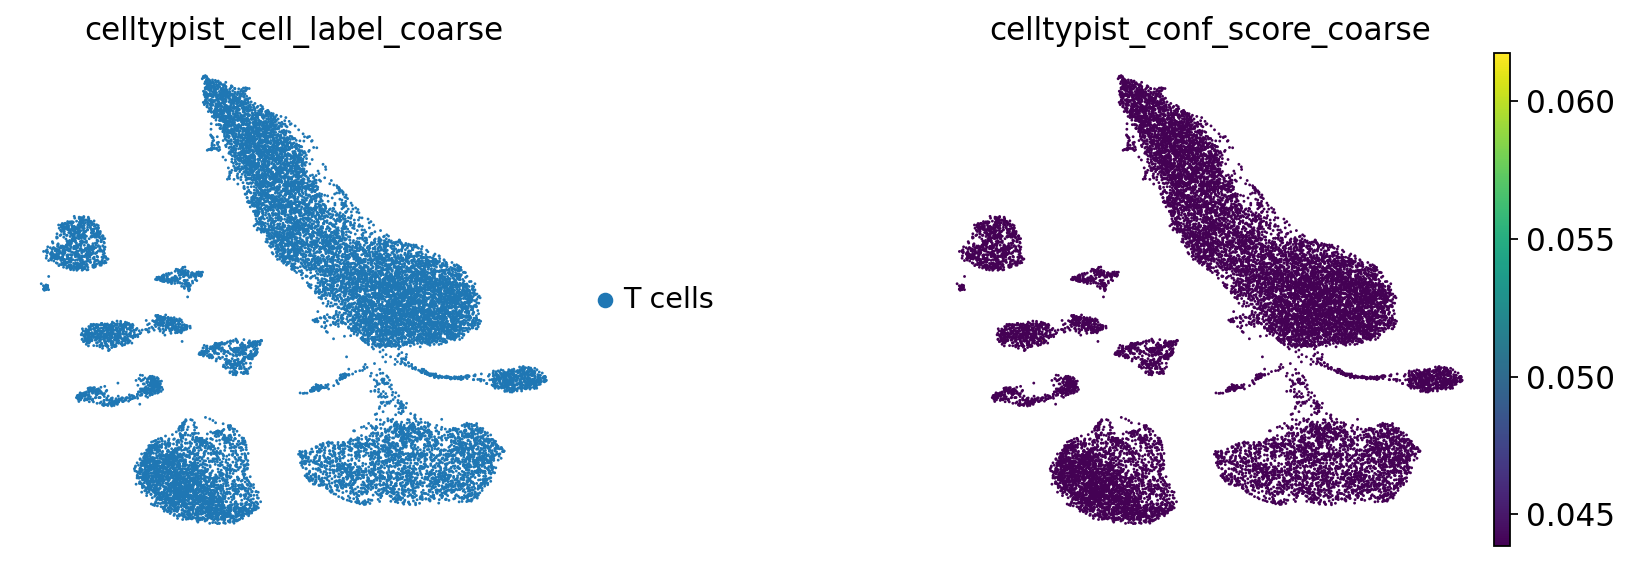

In [13]:
# 11.4 可视化结果
# 11.4.1 绘制UMAP图，显示高分辨率细胞类型信息和置信度分数
sc.pl.umap(
    adata,
    color=[
        # "leiden_0_25",
        "celltypist_cell_label_coarse",
        "celltypist_conf_score_coarse",
    ],
    frameon=False,
    sort_order=False,
    wspace=0.5,
    save="-6.4低分辨率注释.pdf",
    # vmin="p00",
    # vmax="p100",
)

In [ ]:
# 11.4.2 绘制UMAP图，显示低分辨率细胞类型信息和置信度分数
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"],
    frameon=False,
    sort_order=False,
    wspace=1,
    save="-6.4高分辨率注释.pdf",
)

In [ ]:
# 11.4.3 TODO: 聚类树偶尔报错的
# sc.pl.dendrogram(adata, groupby="celltypist_cell_label_fine")

In [ ]:
# 11.5 分析之前的手动注释
# 显示之前手动注释的细胞类型信息
sc.pl.umap(
    adata,
    color=["leiden_2"] + ["celltypist_cell_label_coarse"],
    # legend_loc="on data",
    legend_fontsize=10,
    ncols=2,
    frameon=False,
    # edges=True,
    # components="all",
    # add_outline=True,
    # legend_fontoutline=6,
    save="-6.5celltypist_cell_label_coarse.pdf",
)

In [ ]:
# 11.6 进一步分析
# 用于分析Leiden社区的交叉表格
# 看每个聚类的个细胞占比
# pd.crosstab(adata.obs.leiden_0_25, adata.obs.celltypist_cell_label_coarse).loc[
#     "7", :
# ].sort_values(ascending=False)

In [ ]:
adata.obs["celltypist_cell_label_coarse"].value_counts()

In [ ]:
# 11.7 保存
adata.write("anndata_celltypist_anno.h5ad", compression="gzip")  # type: ignore